In [17]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch
import torch.nn.functional as f
import math

In [5]:
from ale_py import ALEInterface
ale = ALEInterface()

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [6]:
from ale_py.roms import Skiing
ale.loadROM(Skiing)

Game console created:
  ROM file:  /home/makinoharafan1/code/rl-atari-skiing/rl-skiing/lib/python3.11/site-packages/AutoROM/roms/skiing.bin
  Cart Name: Skiing (1980) (Activision) [!]
  Cart MD5:  b76fbadc8ffb1f83e2ca08b6fb4d6c9f
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 1715014731


In [7]:
from typing import Any, Text

from ale_py.env import gym as ale_gym

# Patch to allow rendering Atari games.
# The AtariEnv's render method expects the mode to be in self._render_mode
# (usually initialized with env.make) instead of taking mode as a param.
_original_atari_render = ale_gym.AtariEnv.render


def atari_render(self, mode: Text = 'rgb_array') -> Any:
  original_render_mode = self._render_mode
  try:
    self._render_mode = mode
    return _original_atari_render(self)
  finally:
    self._render_mode = original_render_mode


ale_gym.AtariEnv.render = atari_render

In [124]:
env = gym.make('ALE/Skiing-v5')

In [21]:
def get_pos_player(observe):
    ids = np.where(np.sum(observe == [214, 92, 92], -1) == 3)
    if len(ids[0]) == 0:
        return 0, 0  
    else:
        return int(ids[0].mean()), int(ids[1].mean())

In [22]:
def get_pos_flags(observe):
    if np.any(np.sum(observe == [184, 50, 50], -1) == 3):
        ids = np.where(np.sum(observe == [184, 50, 50], -1) == 3)
        return int(ids[0].mean()), int(ids[1].mean())
    else:
        base = 0
        ids = np.where(np.sum(observe[base:-60] == [66, 72, 200], -1) == 3)
        if len(ids[0]) == 0:
            return 0, 0  
        else:
            return int(ids[0].mean() + base), int(ids[1].mean())

In [86]:
class ActorCriticModel(nn.Module):
  def __init__(self, n_input, n_output, n_hidden):
    super(ActorCriticModel, self).__init__()
    self.fc = nn.Linear(n_input, n_hidden)
    self.action = nn.Linear(n_hidden, n_output)
    self.value = nn.Linear(n_hidden, 1)

  def forward(self, x):
    x = torch.Tensor(x)
    x = f.relu(self.fc(x))

    action_probs = f.softmax(self.action(x), dim=-1)
    state_value = self.value(x)
    
    return action_probs, state_value

In [85]:
class PolicyNetwork():
  def __init__(self, n_state, n_action, n_hidden=50, lr=0.001):
    self.model = ActorCriticModel(n_state, n_action, n_hidden)
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

  def predict(self, s):
    return self.model(torch.Tensor(s))

  def update(self, returns, log_probs, state_values):
    loss = 0
    for log_prob, value, Gt in zip(log_probs, state_values, returns):
      adventage = Gt - value.item()
      policy_loss = - log_prob * adventage
      value_loss = f.smooth_l1_loss(value, Gt)
      loss += policy_loss + value_loss

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

  def get_action(self, s):
    action_probs, state_value = self.predict(s)
    action = torch.multinomial(action_probs, 1).item()
    log_prob = torch.log(action_probs[action])
    return action, log_prob, state_value

In [132]:
def actor_critic(env, estimator, n_episode, gamma=1.0):
  for episode in range(n_episode):
    log_probs = []
    rewards = []
    state_values = []

    state = env.reset()
    
    state = cv2.cvtColor(cv2.resize(state[0], (100, 60)), cv2.COLOR_BGR2GRAY).flatten().tolist()
    
    while True:
      action, log_prob, state_value = estimator.get_action(state)
      next_state, reward, is_done, _, _ = env.step(action)

      player_pos = get_pos_player(next_state)
      flags_pos = get_pos_flags(next_state)

      distance = -math.sqrt((player_pos[0] - flags_pos[0]) ** 2 + (player_pos[1] - flags_pos[1]) ** 2)

      next_state = cv2.cvtColor(cv2.resize(next_state, (100, 60)), cv2.COLOR_BGR2GRAY).flatten().tolist()

      total_reward_episode[episode] += reward


      log_probs.append(log_prob)
      rewards.append(distance)
      state_values.append(state_value)

      if is_done:
        returns = []
        Gt = 0
        pw = 0
        for reward in rewards[::-1]:
          Gt += gamma ** pw * reward
          pw += 1
          returns.append(Gt)

        returns = returns[::-1]
        returns = torch.tensor(returns)
        returns = (returns - torch.mean(returns)) / (torch.std(returns) + 1e-9)
        estimator.update(returns, log_probs, state_values)

        break

      state = next_state

    print(total_reward_episode[episode])

In [143]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 32
lr = 0.1
policy_net = PolicyNetwork(6000, n_action, n_hidden, lr)

n_episode = 300
gamma = 0.9
total_reward_episode = [0] * n_episode

In [144]:
env.reset()
actor_critic(env, policy_net, n_episode, gamma)

/tmp/ipykernel_9127/4093770437.py:15: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = f.smooth_l1_loss(value, Gt)


-30000.0
-30000.0
-30000.0
-14618.0
-17221.0
-17592.0
-14731.0
-16535.0
-15282.0
-16889.0
-19402.0
-23144.0
-21249.0
-25644.0
-25298.0
-30117.0
-18699.0
-26588.0
-23481.0
-18299.0
-20118.0
-19737.0
-17376.0
-16497.0
-18346.0
-17241.0
-15429.0
-19329.0
-19883.0
-20598.0
-22796.0
-15505.0
-13671.0
-20161.0
-22153.0
-15171.0
-21099.0
-17955.0
-14535.0
-17269.0
-16374.0
-15999.0
-14000.0
-20530.0
-18636.0
-20022.0
-14349.0
-15417.0
-18895.0
-19014.0
-17903.0
-13749.0
-19643.0
-19138.0
-18848.0
-20272.0
-18464.0
-17573.0
-16932.0
-15650.0
-27616.0
-18942.0
-16508.0
-18959.0
-20143.0
-21692.0
-21401.0
-20241.0
-21685.0
-20441.0
-17601.0
-13842.0
-13822.0
-19589.0
-15856.0
-20649.0
-22991.0
-19707.0
-16149.0
-13486.0
-21123.0
-11869.0
-16817.0
-13993.0
-15513.0
-16532.0
-17324.0
-17380.0
-12060.0
-14734.0
-14135.0
-14214.0
-17009.0
-14209.0
-13258.0
-14662.0
-15186.0
-16951.0
-14476.0
-15708.0
-16344.0
-10620.0
-16779.0
-14957.0
-18002.0
-19504.0
-14032.0
-12090.0
-16918.0
-16542.0
-15036.0
-

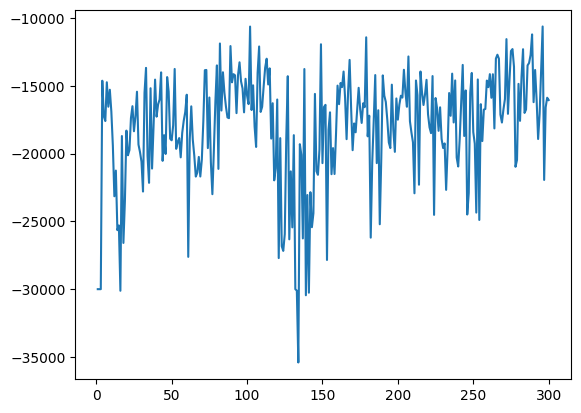

In [145]:
plt.plot(np.arange(1, n_episode + 1), total_reward_episode)
plt.show()

## Точечная оценка J

In [147]:
mean_reward = np.mean(total_reward_episode)
mean_reward

-18011.513333333332

## Интервальная оценка J

95.0% Confidence Interval: [-30000.0, -12074.25]


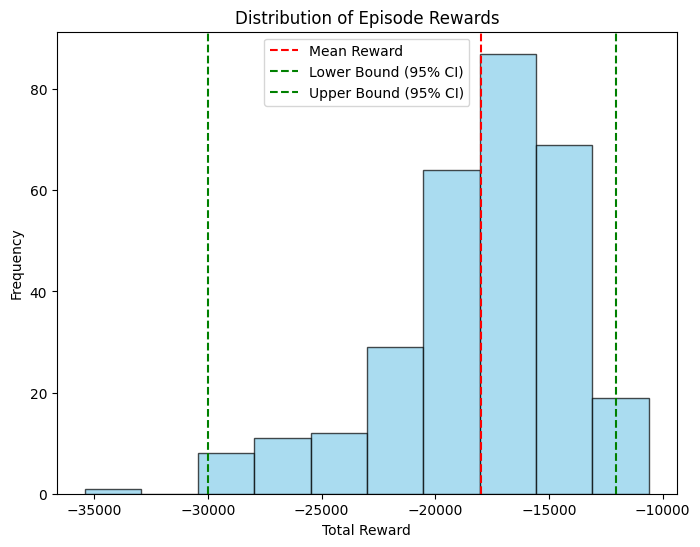

In [148]:
confidence_level = 0.95
lower_percentile = (1 - confidence_level) / 2 * 100
upper_percentile = (1 + confidence_level) / 2 * 100

lower_bound = np.percentile(total_reward_episode, lower_percentile)
upper_bound = np.percentile(total_reward_episode, upper_percentile)

print(f"{confidence_level * 100}% Confidence Interval: [{lower_bound}, {upper_bound}]")

plt.figure(figsize=(8, 6))
plt.hist(total_reward_episode, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=mean_reward, color='red', linestyle='--', label='Mean Reward')
plt.axvline(x=lower_bound, color='green', linestyle='--', label='Lower Bound (95% CI)')
plt.axvline(x=upper_bound, color='green', linestyle='--', label='Upper Bound (95% CI)')
plt.xlabel('Total Reward')
plt.ylabel('Frequency')
plt.title('Distribution of Episode Rewards')
plt.legend()
plt.show()